### 2D Seismic Profile - Segy Loading

In [23]:
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segyio
from os.path import isfile, join
from os import walk
import time
import cv2
import math

# Load segy file using segyio package

In [24]:
filename = 'seismic_images/sgy_data/HR-IL2800.sgy'

In [25]:
def FileExists(file):
    if (os.path.isfile(file)):
        print('File exists')
    else:
        print('File does not exist or could not be found')
FileExists(filename)

File exists


In [26]:
# trace header and text header functions

def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [27]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers - binary header, text header and trace header
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 3921, N Samples: 701, Sample rate: 1.0ms'

In [28]:
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

'The 99th percentile is 6; the max amplitude is 19'

Text(0.5, 1.0, 'HR-IL2800.SGY')

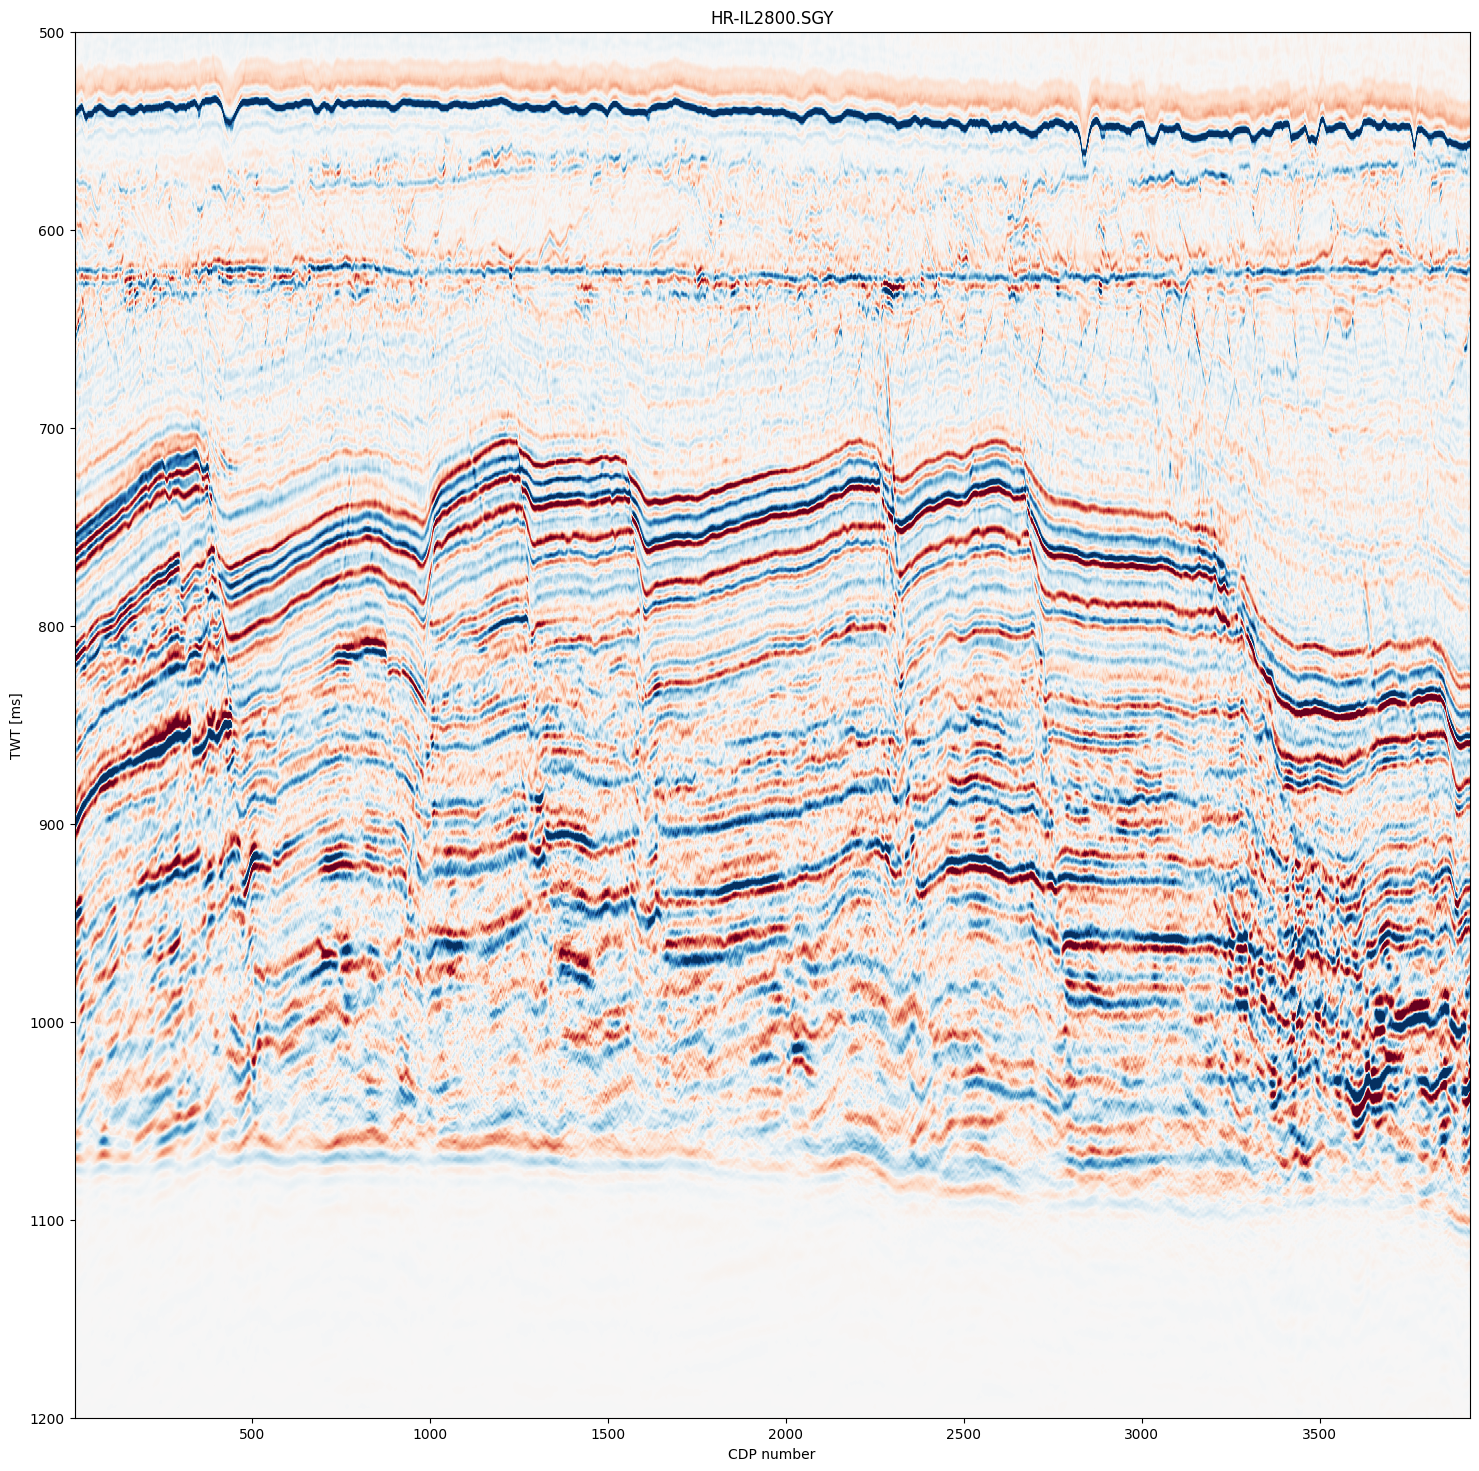

In [29]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_traces, twt[-1], twt[0]]  # define extent
ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
# optional colormap "gray_r" or "RdBu"
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title(f'HR-IL2800.SGY')

In [30]:
data.shape

(3921, 701)

In [31]:
def load_seismic(seismics_path): # read and store all file names in order
    for (_, _, filenames) in walk(seismics_path):
        segy = sorted(filenames)

    print("number of data files in the folder: ",len(segy))
    print("seismics_path: ", seismics_path)
    print(segy[:10])

    return seismics_path, segy

In [32]:
seis_path = 'seismic_images/sgy_data'
seismics_path,seismics = load_seismic(seis_path)

number of data files in the folder:  126
seismics_path:  seismic_images/sgy_data
['HR-IL2800.crsmeta.sgy', 'HR-IL2800.sgy', 'HR-IL2900.segy.crsmeta.sgy', 'HR-IL2900.sgy', 'HR-IL3000.segy.crsmeta.sgy', 'HR-IL3000.sgy', 'HR-IL3100.segy.crsmeta.sgy', 'HR-IL3100.sgy', 'HR-IL3200.segy.crsmeta.sgy', 'HR-IL3200.sgy']


---------
### 3D Seismic Volumn - Segy Loading

In [33]:
local_file = 'f3-dsmf.sgy'
inlines,xlines,twt='','',''

with segyio.open(local_file,"r") as f:
    inlines,xlines,twt =f.ilines, f.xlines, f.samples

print("Inline range:", np.amin(inlines), "-", np.amax(inlines), ", count:", inlines.shape[0])
print("Xline range:", np.amin(xlines), "-", np.amax(xlines), ", count:", xlines.shape[0])
print("TWT range [ms]:", np.amin(twt), "-", np.amax(twt), ", count", twt.shape[0])

Inline range: 200 - 600 , count: 401
Xline range: 500 - 1100 , count: 601
TWT range [ms]: 200.0 - 1500.0 , count 326


In [34]:
# calculating steps by substracting adjacent elements
il_st = np.unique(inlines)[1]-np.unique(inlines)[0]
xl_st = np.unique(xlines)[1]-np.unique(xlines)[0]
twt_st = np.unique(twt)[1]-np.unique(twt)[0]
print("IL/XL and TWT[ms] step:", il_st, ",", xl_st, ",", twt_st) 

IL/XL and TWT[ms] step: 1 , 1 , 4.0


In [35]:
# read seismic data and print out 3D shape
seismic_data = segyio.tools.cube(local_file)
print("Survey IL/XL/TWT shape:", seismic_data.shape[0], "/", seismic_data.shape[1], "/", seismic_data.shape[2])

Survey IL/XL/TWT shape: 401 / 601 / 326


In [36]:
def set_position_label(interval,tick, step, start_value):
    positions = np.arange(0, interval, tick/step)
    labels = positions * step + start_value
    labels = labels.astype(int)
    return positions, labels

# step between tick labels for inlines, xlines and twt
il_tl = 100 
xl_tl = 100
twt_tl = 200

# Step between tick labels for inlines, xlines, and twt

il_pos, il_lab = set_position_label(seismic_data.shape[0], il_tl, il_st, inlines[0])
xl_pos, xl_lab = set_position_label(seismic_data.shape[1], xl_tl, xl_st, xlines[0])
twt_pos, twt_lab = set_position_label(seismic_data.shape[2], twt_tl,twt_st, twt[0] )

print(f"il ticks positions = {il_pos} and labels ={il_lab}",
      f"\nxl ticks positions = {xl_pos} and labels ={xl_lab}",
      f"\ntwt ticks positions = {twt_pos} and labels = {twt_lab}")

il ticks positions = [  0. 100. 200. 300. 400.] and labels =[200 300 400 500 600] 
xl ticks positions = [  0. 100. 200. 300. 400. 500. 600.] and labels =[ 500  600  700  800  900 1000 1100] 
twt ticks positions = [  0.  50. 100. 150. 200. 250. 300.] and labels = [ 200  400  600  800 1000 1200 1400]


Text(0.5, 1.0, 'Inline = 201')

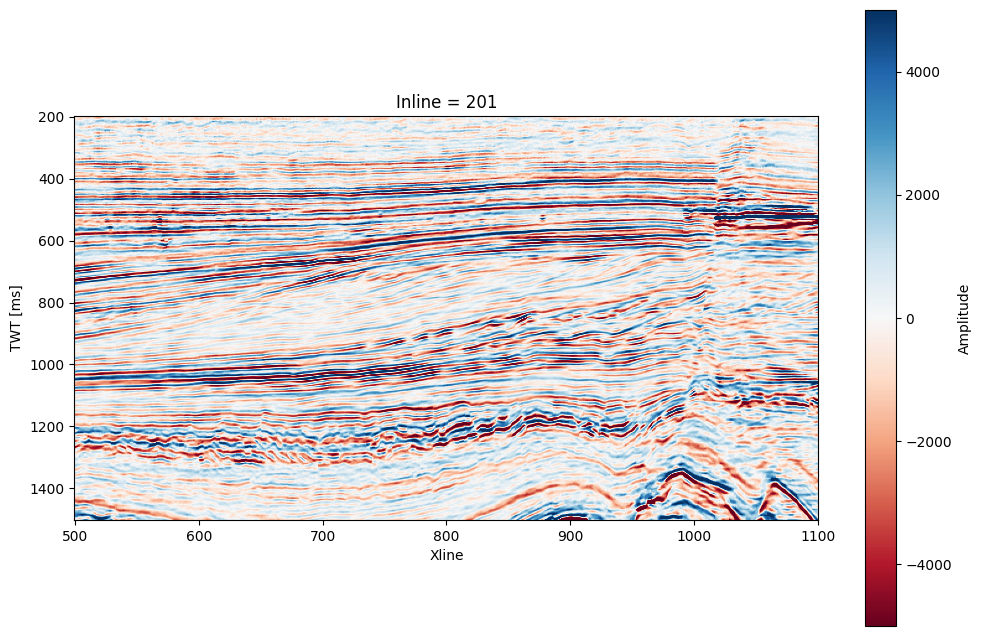

In [37]:
# plot Inline

# inline index
il_id = 1
fig, ax = plt.subplots(figsize=(12,8)) # create figure
sim = ax.imshow(seismic_data[il_id,:,:].T, cmap="RdBu", vmin=-5000, vmax=5000)
# or colormap option cmap="gray_r"
fig.colorbar(sim, label="Amplitude")

plt.xticks(xl_pos, xl_lab)

plt.yticks(twt_pos, twt_lab)

ax.set_xlabel("Xline") 
ax.set_ylabel("TWT [ms]") 
ax.set_title("Inline = " + str(inlines[il_id]))